In [105]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xlrd

### Load datasets

In [106]:
exp_file = r'C:\Users\USYS671257\WSP O365\chattanooga-modeling - RTP TDM Update\Deliverables\Task 3_Model Validation\survey_expansion\01052016_Data_Cleaning_19.xlsx'
taz_file = r'C:\Users\USYS671257\WSP O365\chattanooga-modeling - RTP TDM Update\Data\TAZ.shp'

dir_path = r'C:\Users\USYS671257\OneDrive - WSP O365\21_31000110.002_Chattanooga TPO Model\1-ridership_survey_expansion'
survey_geo_file = 'survey_geocoded_rev.csv'
survey_geo_export = 'survey_geocoded_{}.shp'
survey_expanded_export = 'survey_expanded.csv'

d_types = {'RespondentID': str}

##### Function for Temp fix of NA ID with Route

In [107]:
def fix_with_route(df):
    df.loc[df['RespondentID'].isna(), 'RespondentID'] = df['Route '].apply(lambda x: str(x).split('-')[0])

##### Load Survey Expansion

In [108]:
survey_exp = pd.read_excel(exp_file, sheet_name='Sheet2')
survey_exp = survey_exp[['RespondentID_new','RespondentID', 'Route ', 'linked trip weight', 'unlinked weight (boarding weight)']].copy()

#Fix NA
fix_with_route(survey_exp)

##### Load SED datasets

In [109]:
taz = gpd.read_file(taz_file)
taz = taz[['TAZ_ID', 'DISTRICT', 'geometry']].copy()

epsg:2274


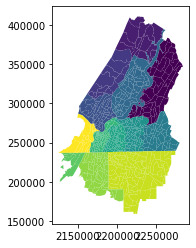

In [110]:
print(taz.crs)
taz.plot(column='DISTRICT')

##### Load Survey Geocode Results

In [111]:
survey_geo = pd.read_csv(os.path.join(dir_path, survey_geo_file))
#Fix NA
fix_with_route(survey_geo)

# print(list(survey_geo))
survey_geo = survey_geo[[
    'RespondentID',
    'lat_left',
    'lng_left',
    'lat_dest',
    'lng_dest',
    'Geocode_result_left',
    'Geocode_result_dest',
    'Left_Add_EDIT',
    'lat_left_EDIT',
    'lng_left_EDIT',
    'Dest_Add_EDIT',
    'lat_dest_EDIT',
    'lng_dest_EDIT'
]].copy()

##### Consolidate Geocode results from Automated and Manual process

In [112]:
cols = ['{}_{}'.format(c,p) for p in ['left', 'dest'] for c in ['lat', 'lng']]

for col in cols:
    survey_geo[col] = survey_geo['{}_EDIT'.format(col)].combine_first(survey_geo[col])
    
survey_geo.loc[survey_geo['Left_Add_EDIT'].notna(), 'Geocode_result_left'] = 'manual'
survey_geo.loc[survey_geo['Dest_Add_EDIT'].notna(), 'Geocode_result_dest'] = 'manual'

### Overlay with SED, for 'Left' and 'Dest' locations

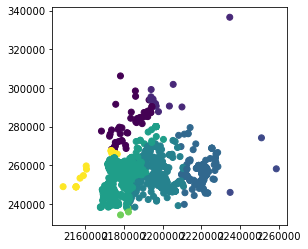

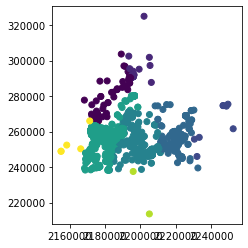

In [113]:
### Use only records with accepted Geocode results
geo_pass = ['pass', 'manual']
surveys = {}

for l in ['left', 'dest']:
    lat = 'lat_{}'.format(l)
    lng = 'lng_{}'.format(l)
    Geocode_result = 'Geocode_result_{}'.format(l)
    geo_cols = ['RespondentID', lat, lng, Geocode_result]
    taz_columns = {col: '{}_{}'.format(col, l.upper()) for col in ['TAZ_ID', 'DISTRICT']}
    
    surveys[l] = survey_geo[survey_geo[Geocode_result].isin(geo_pass)]
    
    surveys[l] = gpd.GeoDataFrame(surveys[l][geo_cols],
                              geometry=[Point(xy) for xy in zip(surveys[l][lng], surveys[l][lat])],
                              crs='epsg:4326'
                             ).to_crs(epsg=2274)
    
    surveys[l] = gpd.sjoin(surveys[l], taz, how='inner')
    surveys[l] = surveys[l].rename(columns = taz_columns)
    
    surveys[l].plot(column='DISTRICT_{}'.format(l.upper()))
    
#     # To Shapefile
#     surveys[l] = surveys[l][['RespondentID']+[*taz_columns.values()]+['geometry']]
#     surveys[l].to_file(os.path.join(dir_path, survey_geo_export.format(l)))
    
    surveys[l] = surveys[l][['RespondentID']+[*taz_columns.values()]]

### Join to Expansion Values table

In [114]:
for srv in surveys.values():
    survey_exp = pd.merge(survey_exp, srv, how='inner', on='RespondentID')

### Export to .csv

In [115]:
survey_exp.to_csv(os.path.join(dir_path, survey_expanded_export), index=False)
print('Expanded Survey with O/D exported to: {}'.format(os.path.join(dir_path, survey_expanded_export)))

survey_exp.head()

Expanded Survey with O/D exported to: C:\Users\USYS671257\OneDrive - WSP O365\21_31000110.002_Chattanooga TPO Model\1-ridership_survey_expansion\survey_expanded.csv


,RespondentID_new,RespondentID,Route,linked trip weight,unlinked weight (boarding weight),TAZ_ID_LEFT,DISTRICT_LEFT,TAZ_ID_DEST,DISTRICT_DEST
0,1,4.19933e+09,10- East Chattanooga,3.184783,6.369566,897,8.0,410,9.0
1,3,4.20607e+09,10- East Chattanooga,3.184783,3.184783,434,8.0,752,9.0
2,4,4.20963e+09,21- Golden Gateway,2.755814,8.267442,731,9.0,752,9.0
3,5,4.20971e+09,8- Eastdale,1.421053,4.263159,336,8.0,472,7.0
4,6,4.21002e+09,1- Alton Park,2.488372,4.976744,272,9.0,272,9.0


### Trips by Time of Day

In [117]:
survey_raw = pd.read_excel(exp_file, sheet_name='cleaned except O&D address')
survey_raw = survey_raw[['RespondentID_new', 'Time - Hour', 'Time - AM/PM_new', 'Time', 'Time Trip Began']].copy()
# survey_raw['RespondentID'] = survey_raw['RespondentID'].astype(str)

In [221]:
survey_raw.head()

,RespondentID_new,Time - Hour,Time - AM/PM_new,Time,Time Trip Began
0,1,6.0,AM,6:30 AM,3-5 PM
1,2,6.0,AM,6:30 AM,4:30-7 AM
2,3,8.0,AM,08:30:00,7-9 AM
3,4,6.0,AM,06:00:00,4:30-7 AM
4,5,10.0,AM,10:10 AM,9-11 AM


In [119]:
survey_exp = survey_exp.merge(survey_raw, on="RespondentID_new", how="left")
survey_exp["Time - Hour"] = survey_exp["Time - Hour"].astype(str)
survey_exp["Time - AM/PM_new"] = survey_exp["Time - AM/PM_new"].astype(str)
survey_exp["Time_Hr_AMPM"] = survey_exp["Time - Hour"] + survey_exp["Time - AM/PM_new"]

In [124]:
survey_exp["Time Trip Began"].value_counts(sort=False)

7-9 PM         25
7-9 AM        277
1-3 PM        176
9-11:30 PM      6
9-11 AM       179
3-5 PM        162
11AM-1 PM     160
5-7 PM         80
4:30-7 AM     195
Name: Time Trip Began, dtype: int64

In [125]:
survey_exp["Time_Hr_AMPM"].value_counts(sort=False)

3.0PM     105
10.0AM     83
4.0AM       2
4.0PM     114
6.0AM      60
2.0PM     104
nan0       30
12.0PM    108
nanAM       3
11.0PM      4
9.0PM       4
8.0PM      10
7.0PM      30
5.0PM      86
9.0AM      74
5.0AM      35
1.0PM     100
11.0AM     70
8.0AM      90
6.0PM      57
12.0AM      4
10.0PM      1
7.0AM      97
nanPM       3
Name: Time_Hr_AMPM, dtype: int64

In [126]:
# classify tod using "time_hr_am/pm"
AM = ["6.0AM","8.0AM","7.0AM"]
PM = ["3.0PM","4.0PM","5.0PM"]
OP = ["10.0AM","4.0AM","2.0PM","12.0PM","11.0PM","9.0PM","8.0PM","7.0PM","9.0AM","5.0AM","1.0PM","11.0AM","6.0PM","12.0AM","10.0PM"]

survey_exp["TOD1"] = "none"
survey_exp.loc[survey_exp["Time_Hr_AMPM"].isin(AM), "TOD1"] = "AM"
survey_exp.loc[survey_exp["Time_Hr_AMPM"].isin(PM), "TOD1"] = "PM"
survey_exp.loc[survey_exp["Time_Hr_AMPM"].isin(OP), "TOD1"] = "OP"

In [127]:
# classify tod using "time trip began"
survey_exp["TOD2"] = "none"
survey_exp.loc[survey_exp["Time Trip Began"]=="7-9 PM", "TOD2"] = "OP"
survey_exp.loc[survey_exp["Time Trip Began"]=="7-9 AM", "TOD2"] = "AM"
survey_exp.loc[survey_exp["Time Trip Began"]=="1-3 PM", "TOD2"] = "OP"
survey_exp.loc[survey_exp["Time Trip Began"]=="9-11:30 PM", "TOD2"] = "OP"
survey_exp.loc[survey_exp["Time Trip Began"]=="9-11 AM", "TOD2"] = "OP"
survey_exp.loc[survey_exp["Time Trip Began"]=="3-5 PM", "TOD2"] = "PM"
survey_exp.loc[survey_exp["Time Trip Began"]=="11AM-1 PM", "TOD2"] = "OP"
survey_exp.loc[survey_exp["Time Trip Began"]=="5-7 PM", "TOD2"] = "PM"
survey_exp.loc[survey_exp["Time Trip Began"]=="4:30-7 AM", "TOD2"] = "AM"

In [128]:
# combine two classifications make sure all trips are tagged with tod
survey_exp["TOD"] = "none"
survey_exp.loc[survey_exp["TOD1"]=="AM", "TOD"] = "AM"
survey_exp.loc[survey_exp["TOD1"]=="PM", "TOD"] = "PM"
survey_exp.loc[survey_exp["TOD1"]=="OP", "TOD"] = "OP"
survey_exp.loc[survey_exp["TOD1"]=="none", "TOD"] = survey_exp["TOD2"]

In [130]:
survey_exp["TOD"].value_counts(sort=False)

PM    307
OP    706
AM    261
Name: TOD, dtype: int64

### Explode rows

In [135]:
explode_col = 'linked trip weight'

for i, row in survey_exp.iterrows():
    if round(row[explode_col])-1 != 0:
        survey_exp = survey_exp.append([row]*(round(row[explode_col])-1))

In [211]:
# add a factor expansion variable as a placeholder, 
# each record will have a factor=1 after exploding the rows,
# the factor expansion variable will be used in GISDK later to generate TC tranist trip tables
survey_exp["TREXPFAC"]=1
survey_exp.to_csv(os.path.join(dir_path,"TransitTrip.csv"))
survey_exp.head()

,RespondentID_new,RespondentID,Route,linked trip weight,unlinked weight (boarding weight),TAZ_ID_LEFT,DISTRICT_LEFT,TAZ_ID_DEST,DISTRICT_DEST,Time - Hour,Time - AM/PM_new,Time,Time Trip Began,Hour,Time_Hr_AMPM,TOD1,TOD2,TOD,TREXPFAC
0,1,4.19933e+09,10- East Chattanooga,3.184783,6.369566,897,8.0,410,9.0,6.0,AM,6:30 AM,3-5 PM,6.0,6.0AM,AM,PM,AM,1
1,3,4.20607e+09,10- East Chattanooga,3.184783,3.184783,434,8.0,752,9.0,8.0,AM,08:30:00,7-9 AM,8.0,8.0AM,AM,AM,AM,1
2,4,4.20963e+09,21- Golden Gateway,2.755814,8.267442,731,9.0,752,9.0,6.0,AM,06:00:00,4:30-7 AM,6.0,6.0AM,AM,AM,AM,1
3,5,4.20971e+09,8- Eastdale,1.421053,4.263159,336,8.0,472,7.0,10.0,AM,10:10 AM,9-11 AM,10.0,10.0AM,OP,OP,OP,1
4,6,4.21002e+09,1- Alton Park,2.488372,4.976744,272,9.0,272,9.0,1.0,PM,1:30 PM,7-9 AM,1.0,1.0PM,OP,AM,OP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,1878,4.40199e+09,21- Golden Gateway,2.755814,2.755814,849,9.0,309,4.0,10.0,AM,10:40 AM,9-11 AM,10.0,10.0AM,OP,OP,OP,1
1271,1879,4.40201e+09,21- Golden Gateway,2.755814,8.267442,905,9.0,849,9.0,nan,0,NaN,4:30-7 AM,nan,nan0,none,AM,AM,1
1271,1879,4.40201e+09,21- Golden Gateway,2.755814,8.267442,905,9.0,849,9.0,nan,0,NaN,4:30-7 AM,nan,nan0,none,AM,AM,1
1272,1882,4.40205e+09,1- Alton Park,2.488372,4.976744,905,9.0,734,9.0,nan,0,NaN,4:30-7 AM,nan,nan0,none,AM,AM,1


In [212]:
print('Expanded Trips: {:,}'.format(len(survey_exp)))

survey_exp[survey_exp['RespondentID']==survey_exp['RespondentID'].sample(1).values[0]]
# survey_exp.head()

Expanded Trips: 3,114


,RespondentID_new,RespondentID,Route,linked trip weight,unlinked weight (boarding weight),TAZ_ID_LEFT,DISTRICT_LEFT,TAZ_ID_DEST,DISTRICT_DEST,Time - Hour,Time - AM/PM_new,Time,Time Trip Began,Hour,Time_Hr_AMPM,TOD1,TOD2,TOD,TREXPFAC
950,1432,4.2614e+09,10- East Chattanooga,3.184783,9.554349,731,9.0,466,8.0,1.0,PM,13:00:00,1-3 PM,1.0,1.0PM,OP,OP,OP,1
950,1432,4.2614e+09,10- East Chattanooga,3.184783,9.554349,731,9.0,466,8.0,1.0,PM,13:00:00,1-3 PM,1.0,1.0PM,OP,OP,OP,1
950,1432,4.2614e+09,10- East Chattanooga,3.184783,9.554349,731,9.0,466,8.0,1.0,PM,13:00:00,1-3 PM,1.0,1.0PM,OP,OP,OP,1
